# Write your Own Kernel


## Goals

* Understand the process of building and running applications on the NPU

* Learn about the AI Engine's C++ APIs

* Write your first AI Engine kernel in C++

* Build and run a simple application for the first time using the kernel you wrote



---


## References

**[RGBA Color Model](https://en.wikipedia.org/wiki/RGBA_color_model)**

**[AI Engine's C++ APIs](https://www.xilinx.com/htmldocs/xilinx2023_2/aiengine_api/aie_api/doc/index.html)**


---


## Introduction

This notebook explains the process for building applications on the NPU. Example code is provided for an introductory application which is intended to be easy to understand and verify. You will see the source code for the software kernel that runs in a compute tile. For the NPU graph, a template from the Riallto library is used. Details of NPU graphs will be covered in the next notebook. This notebook will focus on how to build a whole application from kernel source code and a graph template, both of which are provided for you.

You will see the process of building and running the simple application. Once you have successfully completed these steps, you will be shown how to re-use the same graph template with a software kernel that you will write. You will then see how to build and run this custom application. 


---



##  The *pass-through* Application

We will start with a simple _pass-through_ application. For this application the NPU will read an image as the input, move it to a compute tile, and write it back unaltered to our output. This is like a Ryzen AI equivalent to a "hello world" application typically used in C programming. We will not do any real computation in the array, but we will use this application to test that the toolchain and application work correctly.

The NPU and the x86 CPU in the Ryzen 7000 processor share access to external memory. For Ryzen AI laptops this is DDR5 that is shared with the main x86 CPU and also with the iGPU.

<center><img src="./images/png/shared_system_memory.png" style="max-height: 365px; width:auto; height:auto;"></center>
<center><strong>x86 CPU and NPU shared access to external memory </strong></center>

The NPU only has access to this external memory. The CPU has access to all system peripherals and is responsible for providing input data to the NPU and reading back the results. For example, the CPU can read data from a webcam, make it available to the NPU, read back the results, and display them on a laptop's screen.  

The NPU application needs an input data buffer and an output data buffer. Data buffers in this context mean area(s) in memory where data will temporarily reside as it is processed by the NPU. The input and output data buffers will be allocated by the x86 processor in external memory.  

The x86 CPU will allocate these buffers, load the input buffer with the initial image, and allow the NPU to read from it. Once the NPU has processed the image, it will save the results in the output buffer, which the CPU can access.

For this application, the input and returned output image will be identical.

The CPU is also responsible for launching the application on the NPU. The Python code in this notebook handles buffer allocation, reads image data from a file, places it into the input buffer, and later retrieves it from the output buffer. The software kernel on the NPU simply reads data from the input buffer and writes it to the output buffer without making any changes, hence the name *pass-through* kernel.

### Dataflow graph and predefined template

In section 3, we introduced a color threshold example application. The dataflow graph for our pass-through application and its mapping to the NPU closely resemble the color threshold example. The main differences are as follows:


* Basic pass-through kernel
    * Our pass-through kernel is simpler; it reads the input data and writes the same data as output


* Single 720p [RGBA](https://en.wikipedia.org/wiki/RGBA_color_model) image
    * Our application processes a single 720p RGBA image at a time, as opposed to a continuous video stream


* Predefined graph template
    * We use a predefined graph template known as the `RGB720pBuilder` template, which is available from the Riallto `npu` package


#### Riallto RGB720pBuilder template

<div class="alert alert-box alert-info">

Data movement both in space and time to/from the kernel is defined by the graph. In this example, the data movement is provided by `RGB720pBuilder`.

</div>

The pre-defined `RGB720pBuilder` is a mapped dataflow graph that uses an interface tile and a single compute tile in an NPU column. We say "mapped" here because the application is mapped to specific tiles in the column - in this case the template is configured to use the bottom compute tile in a column. The interface tile data movers are pre-configured to handle _720p_ RGBA images (1280x720 pixels).  They pass the data to the first compute tile and move the resulting data from the compute tile back to external memory. 

The application will process an entire row of the image at a time. This is the tiling process we described in an earlier notebook. Each RGBA pixel (Red, Green, Blue, Alpha) is 32-bits or 4-bytes and there are 1,280 pixels in a row. The data movers are pre-configured for  transfers of 4 x 1,280 = 5,120 bytes. 

The dataflow graph for this application is illustrated below, along with its mapping to a section of an NPU column. Note again that only one compute tile is used for this application and that this is the compute tile at the bottom of an NPU column. For simplicity, the three empty compute tiles in the rest of the column are not shown here. 

The use of the bottom compute tile is important because the graph has been configured to work specifically with this tile, as defined in the template graph.

<center><img src="./images/svg/pass-through_DFG_and_Mapping.svg" style="max-height: 400px; width:auto; height:auto;"></center>
<center><strong>Pass-through DFG and mapping with <em>RGB720pBuilder</em></strong></center>

In later notebooks, you will see how to write kernels for more than one compute tile, how to create your own mapped dataflow graph, and how to build the complete application for the Ryzen AI NPU. For now, this is a convenient way to get started. We can ignore details of the graph initially and focus first on how software kernels are written and how the whole application is built and executed.

Execute each code cell below as you progress through the notebook.  

---


## Resources Used by the pass-through Application

The resources used in this application are similar to those used in the color threshold example. 

* 1 interface tile
  * 2 data movers
      * 1 for stream input and 1 for stream output
* 1 compute tile with 1 kernel (with the pass-through kernel)
  * 2 memory buffers
      * An input and output memory buffer in the data memory of the compute tile
  * 2 data movers
      * 1 for stream input and 1 for stream output

<div class="alert alert-box alert-info">
     Note that only the stream switch in the memory tile is used in this example
</div>


---


## Define the *pass-through* Software Kernel

The Riallto `npu` Python package is needed for every Riallto notebook. Start by importing this module.

In [1]:
import npu

Next, we will define the simple pass-through kernel. The kernel is written in C++ but is wrapped in a Python object by passing it to our `%%kernel` cell magic. Everything after the first line will be interpreted by the backend tools as C/C++ code.

In [2]:
%%kernel

void passthrough(uint8_t *in_buffer, uint8_t *out_buffer, uint32_t nbytes)
{
    for(int i=0; i<nbytes; i++) {
        out_buffer[i] = in_buffer[i];
    }
}

The `passthrough()` function takes three parameters: `in_buffer`, `out_buffer` and `nbytes`. It copies `nbytes` of data in bytes from one memory location (referred to by `in_buffer`) to another memory location (referred to by `out_buffer`).

This magic creates a Python `Kernel` object called `passthrough` that we will pass later into a graph builder to generate the application. 

We will be able to use the Python kernel object in the Riallto flow to work with the underlying C++ software kernel.

We can check the Python object has been created and verify it is a *Kernel* type:

In [3]:
passthrough

The C code associated with this software kernel will be compiled later into an object file. It will then be linked to the data movement in the graph.


---


## Anatomy of a Kernel

At this stage, let us consider a few points about kernels:

**Input/output buffers**  
When data is pushed to the software kernel (which is running in a compute tile), it is written into a data buffer in the local data memory of the compute tile. The pointers to these buffers will be passed into the software kernel and are references to these buffers. In the signature of the `passthrough` function, there are two buffers:

* `uint8_t *in_buffer`
    * pointer to the input buffer.
* `uint8_t *out_buffer`
    * pointer to the output buffer.

Each of these buffers has type `uint8_t`, which is a type for a unsigned 8-bit integer. In the main body of the C code (in the for loop), we will access these buffers one byte at a time. The size of these buffers (`nbytes`) are defined in the mapped data flow graph. 

**Kernels operate on chunks of data sent to them via the graph**  
Compute tiles have a limited amount of local data memory. Most applications will process much more data than can be stored in the local data memories of the compute tiles. The graph schedules the partition of data into smaller segments for the kernel to process. The data partitioning or the number of bytes in each segment must be explicitly managed by the programmer so our `passthrough` function has a parameter, `nbytes` to specify the number of bytes to be transferred.  The parameter is user-configurable and can be set when the application is running.

The `passthrough()` function iterates over the `nbytes` of data, reading from the input buffer, and writing to the output buffer:

```c++
for(int i=0; i<nbytes; i++) {
    out_buffer[i] = in_buffer[i];
}
```

**When do kernels execute?**  
Execution of a kernel by an AI Engine is triggered when a full payload of data has been received by the compute tile's input buffers. This is controlled by the data movement in the graph. For this application, there is only one input. Compute tiles with several inputs will need to wait until all their buffers are ready before they can execute. 
Once a kernel has completed, data movers in the compute tile move the contents of the output buffer from the tile to their next destination. 


---


## Building the pass-through Application

We need to map our dataflow graph to the NPU so that the compute and data movement requirements of our kernel are met. For this example, we can use a pre-defined Riallto template called `RGB720pBuilder` which we import from the `npu` package's libraries.  The `RGB720pBuilder` is specially designed for RGBA 720p applications that run on a single compute tile with one input and one output buffer. Furthermore, it accesses and moves data in units of 1 image row of 1,280 pixels at a time. We saw earlier this corresponds to transfers of 5,120 bytes at a time.

We will instantiate an object of type `RGB720pBuilder` and parameterize it with our `pass-through` kernel as shown below.

In [4]:
from npu.lib.graphs.graph_1ct import RGB720pBuilder

app_builder = RGB720pBuilder(kernel=passthrough)

We can confirm that the application is being mapped as we expect by calling the `display()` method of our `app_builder` object to render the mapped dataflow graph. Note this graph matches the graph we saw earlier in this notebook. Note that the diagram below shows a whole NPU column (including three empty compute tiles that are not used in the application). The diagram above did not display the top three unused compute tiles. Nonetheless, the two diagrams are functionally identical.

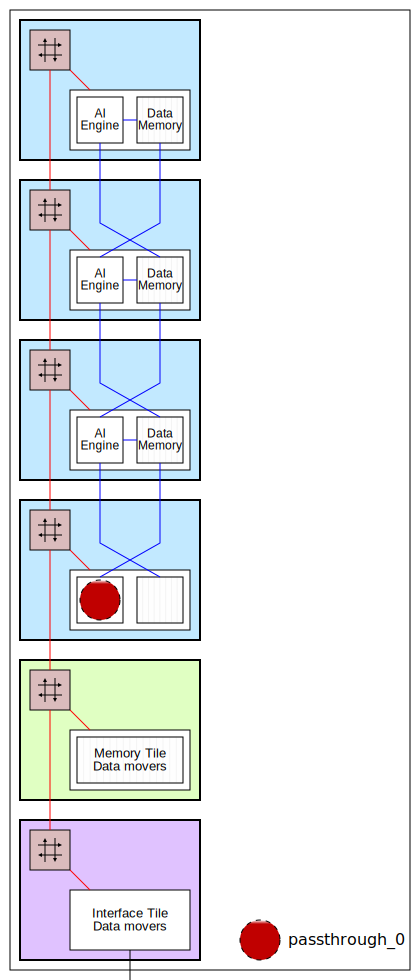

In [5]:
app_builder.display()

The pass-through kernel has been given the name `passthrough_0` and mapped to the bottom compute tile. The visualization shows the interface tile reading data from external memory (not shown), represented by the animated red tokens, and then moving data into the compute tile. This matches the `in_buffer` in our example kernel. The software kernel will start executing. Once it is completed, the compute tile pushes data back to the interface tile which writes the resulting image back to `out_buffer` in external memory.

### Invoking the Application Builder

We have the code for the software kernel, and we have a graph for the dataflow application. We can now build our application by invoking `app_builder.build()` method to create the files we will need to program the NPU.

<div class="alert alert-box alert-info">
     Note that the build process will take about 2 minutes.
</div>

In [6]:
import numpy as np
input_image = np.zeros(shape=(720,1280,4), dtype=np.uint8)
output_image = np.zeros(shape=(720,1280,4), dtype=np.uint8)

app_builder.build(input_image, output_image)

Building the passthrough kernel...
Building the xclbin...
Successfully Building Application... passthrough.xclbin & passthrough.seq delivered


When the build completes successfully, you will see four output files generated in the current directory. 

* `passthrough_0.mlir`
    * contains the MLIR code for the kernel.
* `passthrough_0.seq`
    * contains a runtime sequence for runtime configurable parts of the application along with external data movement sequencing. We will cover this in a later notebook.
* `passthrough_0.json`
    *  The JSON data encompasses details about the application, such as the kernels used, their assignment to tiles, tile connections, and data movement sequencing (equivalent to the information in the passthrough_0.seq file).
* `passthrough_0.xclbin`
    * contains the kernel code binary object for the compute tile, and how the application data movement is configured within the array.

The MLIR file can be opened as a text file if you would like to review the contents, although the MLIR code is not intended to be easily human readable. The sequence file is a sequence of numbers.

[JavaScript Object Notation (JSON)](https://en.wikipedia.org/wiki/JSON) is a lightweight data interchange format. It is a text-based format for representing structured data that is easy for humans to read and write, and easy for machines to parse and generate.

The JSON metadata can also be accessed in a notebook by the `metadata` object:

In [ ]:
app_builder.metadata

Incidentally, the metadata is used to generate the NPU visualizations. 

We will use these files to run our application.


----


## Running an Application

The `OpenCVImageReader()` is a Riallto utility which uses OpenCV to return an RGBA numpy representation of an image file. 

It will be used to load a 720p image for us to experiment with. `image_plot()` displays the image in a notebook.

Run the following code cell to load the image and display it:

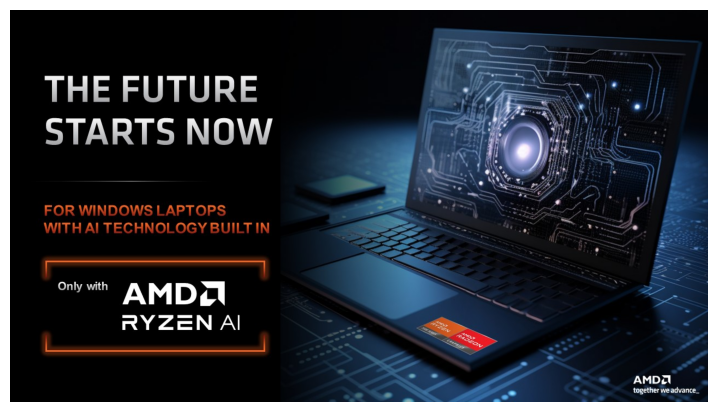

In [8]:
from npu.utils import OpenCVImageReader, image_plot

img = OpenCVImageReader('images/jpg/ryzenai_future_starts_now.jpg').img
image_plot(img)

Next, we will carry out the following steps to run our application:

1. Create an application object from the xclbin we built above.

The `AppRunner` configures the NPU and loads the executable software kernels to all compute tiles used in the application. The software kernels will start running immediately waiting for payload of data.

In [9]:
from npu.runtime import AppRunner

app = AppRunner('passthrough.xclbin')

2. `allocate()` is used to create input and output data buffers with the application object for transferring data into and out of our application. These buffers are created by the x86 CPU and exist in the external DDR5 system memory.

In [10]:
# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(720,1280,4))
output_image = app.allocate(shape=(720,1280,4))

3. Copy the input image into the data buffers.

In [11]:
# Load RGBA 720p image into input_image buffer
input_image[:] = img

The buffers created by the CPU may reside in the x86 cache. The Zen 4 CPU has L1, L2 and L3 cache which must be invalidated and flushed to ensure the copies of the buffers in external memory are up-to-date. 

<center><img src="./images/png/shared_system_memory_sync_calls.png" style="max-height: 365px; width:auto; height:auto;"></center>
<center><strong>Invalidate and flush the cache with synchronization calls </strong></center>

* `sync_to_npu()` is used to flush data from the CPU cache to the input buffer in external memory. It ensures that any modifications made in the CPU cache are reflected in the external memory's input buffer, keeping the data consistent between these two locations. 

* `sync_to_cpu()` is used to invalidate the output memory buffer that may reside in the CPU cache. It guarantees that when the CPU reads the results from this buffer, it retrieves the most recent data in external memory which has been written from the NPU.

In [12]:
# Pass input_image buffer to NPU
input_image.sync_to_npu()

4. Run the application.

`call()` instruct the interface tile to start the data movement based on the application sequence file.

In [13]:
# Run app on NPU
app.call(input_image, output_image)

The last step is to synchronize the output from the NPU. `sync_from_npu()` invalidates the CPU cache for the output memory buffer ensuring the CPU accesses data the buffer from external memory.

In [14]:
# Get results from NPU via output_image buffer 
output_image.sync_from_npu()

### Verify the application output 

We can verify that the image in the output buffer is identical to the input image. Use numpy build-in method to check if the arrays are equal and plot the image.

Are the arrays are equal?: True


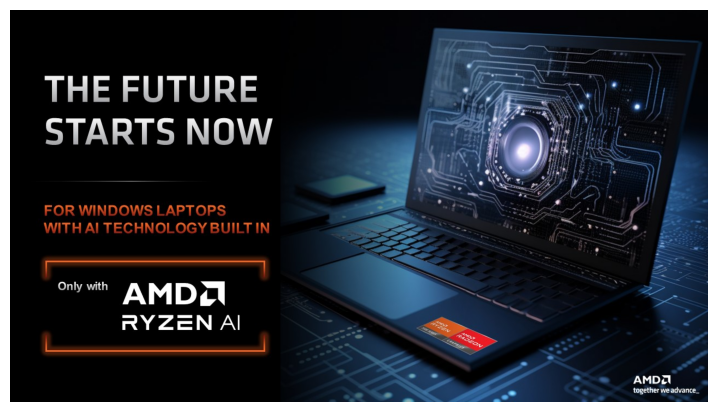

In [15]:
# Compare the arrays for equality
print(f"Are the arrays are equal?: {np.array_equal(input_image, output_image)}")
image_plot(output_image)

Finally, we need to delete the buffers and application, otherwise the application will remain loaded onto the NPU device.

In [16]:
del app


---


## Write your own Kernel and Rebuild the Application

You can now experiment by creating your own software kernel to run on the compute tile. Instead of passing the input image directly to the output as we did earlier, try inverting the image by subtracting 255 from each pixel's RGB bytes, or come up with your own idea.

Your application will use the same graph as we used earlier, so you need to use a 720p image as input. Your application also needs to process the image pixel by pixel.

<div class="alert alert-box alert-warning">

Make sure to leave the fourth byte of each pixel unchanged so that you do not invert the alpha channel values! The alpha channel specifies transparency for the image.

</div>

Modify the C++ code in the cell below to include your own code.

In [ ]:
%%kernel

void mykernel(uint8_t *in_buffer, uint8_t *out_buffer, uint32_t nbytes)
{
    // Your code here <<<<<<

}

Once you have defined your kernel, run the cell below to verify that the mapped data flow graph is identical to the pass-through application.

In [ ]:
myapp = RGB720pBuilder(kernel=mykernel)
myapp.display()

Once you finished your kernel code, run the cell below to build it.

In [ ]:
import numpy as np
input_image = np.zeros(shape=(720,1280,4), dtype=np.uint8)
output_image = np.zeros(shape=(720,1280,4), dtype=np.uint8)

myapp.build(input_image, output_image)

Once it has built, run the next cell to display your output.

In [ ]:
from npu.runtime import AppRunner
my_app = AppRunner('mykernel.xclbin')

input_image = my_app.allocate(shape=(720,1280,4))
output_image = my_app.allocate(shape=(720,1280,4))

input_image[:] = img
input_image.sync_to_npu()

my_app.call(input_image, output_image)

output_image.sync_from_npu()
image_plot(output_image)

Do not forget to tidy up after running your application.

In [ ]:
del my_app


---


## Next Steps

In the next notebook you are going to write a kernel that features Runtime Parameters (RTPs) that can be updated at runtime.


---

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>